<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/Final%20Models/Transformer/TransformerFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tokenizers import normalizers
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
from tokenizers.normalizers import NFD, StripAccents

import os

class EncoderDecoder:
  def __init__(self, model_path="custom-model.json"):
    self.tokenizer = Tokenizer(models.BPE())
    self.model_path = model_path
    self.setup_tokenizer()

  def train_tokenizer(self, corpus, vocab_size=1000):
    trainer = trainers.BpeTrainer(special_tokens=["<pad>", "<unk>", "<s>", "<\s>"], vocab_size=vocab_size)
    self.tokenizer.train_from_iterator(corpus, trainer=trainer)
    # self.save_model()

  def save_model(self):
    model_directory = os.path.dirname(self.model_path)
    os.makedirs(model_directory, exist_ok=True)
    print("Model Path:", self.model_path)
    self.tokenizer.model.save(model_directory, "custom-model")

  def load_model(self):
    self.tokenizer.model = models.BPE.load(self.model_path)

  def setup_tokenizer(self):
    self.tokenizer.normalizer = normalizers.Sequence([NFD(), StripAccents()])
    self.tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
    self.tokenizer.decoder = decoders.ByteLevel()
    self.tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
    self.tokenizer.enable_padding(pad_id=0, pad_token="<pad>")

  def encode(self, text):
    encoding = self.tokenizer.encode(text)
    return encoding.ids

  def decode(self, ids):
    ids_list = ids.tolist()
    tokens = self.tokenizer.decode(ids_list)
    return tokens

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data for training the BPE
with open('/content/drive/MyDrive/training_data.txt', 'r', encoding='utf-8') as file:
  captions = file.read()

print(len(captions)/1e6, 'million words')

30.083569 million words


In [4]:
# encoder-decoder
encoder_decoder = EncoderDecoder()
encoder_decoder.train_tokenizer(captions, vocab_size=10000)
input_data = encoder_decoder.encode(captions)
print("total tokens", len(input_data)/1e5, 'hundred thousand')

total tokens 250.78023 hundred thousand


In [5]:
print(len(encoder_decoder.tokenizer.get_vocab()))

529


In [6]:
# train-test split

n = int(0.9*len(input_data)) # first 90% will be train, rest val
train_data = input_data[:n]
val_data = input_data[n:]
print(f"train data {len(train_data) / 1e3} thousand \n validation data {len(val_data) / 1e3} thousand")

train data 22570.22 thousand 
 validation data 2507.803 thousand


In [ ]:
print("Before trimming:", len(train_data), len(val_data))

# Trimming data for a multiple of 4
train_remainder = len(train_data) % 4
val_remainder = len(val_data) % 4
train_data = train_data[:-train_remainder] if train_remainder != 0 else train_data
val_data = val_data[:-val_remainder] if val_remainder != 0 else val_data

print(len(train_data), len(val_data))

In [7]:
import torch

# Convert to tensors
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)
print(f"train data = {train_data[:10]}, \nval data = {val_data[:10]}")
print(f"train data = {encoder_decoder.decode(train_data[:10])}, val data = {encoder_decoder.decode(val_data[:10])}")

train data = tensor([183,  75,  76,  86, 186,  86, 194,  68,  79,  79]), 
val data = tensor([ 70,  75,  68,  81,  74,  72, 184,  69,  82,  88])
train data =  this is call, val data = change abou


In [8]:
import timeit

start_time_2 = timeit.default_timer()

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 128 # independent sequences process in parallel
block_size = 256 # maximum context length for predictions
max_iters = 2000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 8
n_layer = 8
dropout = 0.2
norm_eps = 1e-05
vocab_size = len(encoder_decoder.tokenizer.get_vocab())
# ------------

torch.manual_seed(1400)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd, eps=norm_eps)
        self.ln2 = nn.LayerNorm(n_embd, eps=norm_eps)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd, eps=norm_eps) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias.data)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
n_param = sum(p.numel() for p in m.parameters())/1e6
print(n_param, 'million')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store step and loss values for visualization
        steps.append(iter)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

14.692369 million
step 0: train loss 6.3979, val loss 6.3987
step 500: train loss 2.0186, val loss 2.0545
step 1000: train loss 1.6711, val loss 1.7260
step 1500: train loss 1.5604, val loss 1.6261
step 1999: train loss 1.4908, val loss 1.5623


In [10]:
model_train = timeit.default_timer()

print(f"time taken to train the model {(model_train - start_time_2) / 3600 } hrs")

time taken to train the model 0.9877082991602778 hrs


In [16]:
# generate from the model
context = 'when I was a kid'
input_tokens = torch.tensor(encoder_decoder.encode(context), dtype=torch.long, device=device)
input_tokens = input_tokens.unsqueeze(0)
print(input_tokens)
generated_output = m.generate(idx=input_tokens, max_new_tokens=100)[0]

print(f"generated output:")
print(f"'{context}' {encoder_decoder.decode(generated_output)}")

tensor([[200,  75,  72,  81, 208, 200,  68,  86, 184, 204,  76,  71]],
       device='cuda:0')
generated output:
'when I was a kid'  when I was a kid then push of wait to the whole ponce best and I do. It's got the discovery of it or wants to do watching describe to that pot o


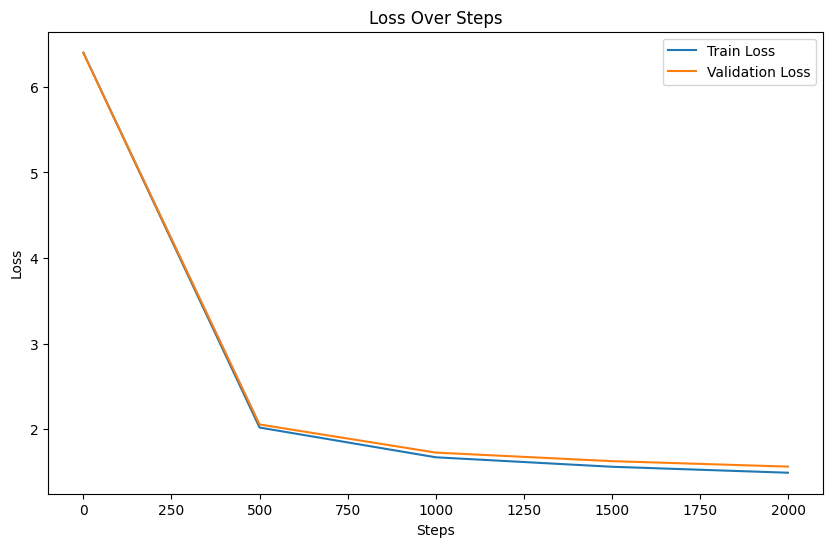

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# summary
end_time = timeit.default_timer()

total_time = (end_time - start_time_2) / 3600

ffn_factor = 4
embedding_params = n_embd * vocab_size
attention_params = n_head * (n_embd // n_head * 2 * n_embd) * n_layer

feedforward_params = n_embd * ffn_factor * n_layer * 2
total_param = sum(p.numel() for p in m.parameters()) / 1e6
total_params = embedding_params + attention_params + feedforward_params

print("///// summary /////")
print(f"total vocab size was {vocab_size}")
print("total no of calculated parameters:", total_params)
print("total no of actual parameters:", total_param)
print(f"time taken to train the model was {(model_train - start_time_2) / 3600} hrs")
print(f"model ran for {max_iters} iterations and final val loss: {val_losses[-1]} and train loss: {train_losses[-1]}")
print('\n', '\n')
print("//// generated output ////")
print(encoder_decoder.decode(generated_output))

///// summary /////
total vocab size was 529
total no of calculated parameters: 2587008
total no of actual parameters: 14.692369
time taken to train the model was 0.9877082991602778 hrs
model ran for 2000 iterations and final val loss: 1.5622766017913818 and train loss: 1.4907718896865845

 

//// generated output ////
 when I was a kid then push of wait to the whole ponce best and I do. It's got the discovery of it or wants to do watching describe to that pot o


In [15]:
torch.save(model.state_dict(), f'{n_param:.2f}million_model.pth')